In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
import json
from definitions import ROOT_DIR
from online.helpers import get_data_from_tb_log, butter_lowpass_filter

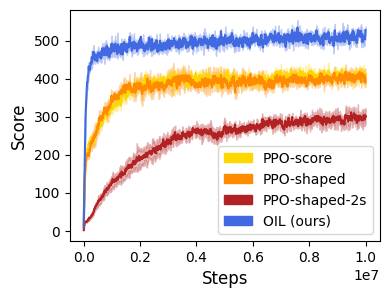

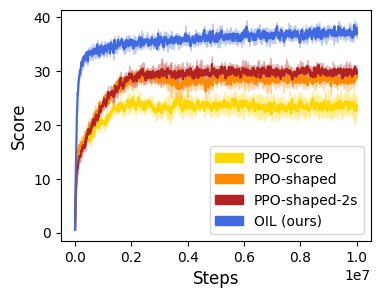

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

for dataset in ["dense", "sparse"]:
    # Paths and attributes
    result_path = ROOT_DIR / "data" / "results" / f"eval_{dataset}.json"
    attr = "score"
    algo_list = ["ppo_score", "ppo_shaped", "ppo_shaped_2_slopes", "oil"]
    color_list = ['gold', 'darkorange', 'firebrick', '#4169E1']
    label_list = ["PPO-score", "PPO-shaped", "PPO-shaped-2s", "OIL (ours)"]

    # Load data
    with open(result_path, 'r') as f:
        data = json.load(f)

    fig, ax = plt.subplots(figsize=(4, 3))

    # Iterate through algorithms, colors, and labels
    for algo, color, label in zip(algo_list, color_list, label_list):
        exp_list = data[algo]
        step_list = []
        attr_list = []
        for exp in exp_list:
            exp_name = exp["experiment"]
            exp_path = ROOT_DIR / "pretrained" / exp_name
            
            # Find the only folder in the experiment path
            tb_folder = [exp_path / f for f in os.listdir(exp_path) if os.path.isdir(exp_path / f)][0]
            tb_file_list = [tb_folder / f for f in os.listdir(exp_path / tb_folder) if "events" in f]
            
            x_list = []
            y_list = []
            for tb_file in tb_file_list:
                # Extract data from TensorBoard logs
                step_dict = get_data_from_tb_log(str(tb_file), attr, x="step")
                
                x_list.append(step_dict[attr][0])
                y_list.append(step_dict[attr][1])
            x = np.concatenate(x_list)
            y = np.concatenate(y_list)
            fs = len(x) / (x[-1] - x[0])
            y = butter_lowpass_filter(y, cutoff=1e-5, fs=fs, order=1)
            step_list.append(x)
            attr_list.append(y)
            
        # Plot mean and std (shaded area)
        min_len = min([len(l) for l in step_list])
        step_list = [s[:min_len] for s in step_list]
        attr_list = [a[:min_len] for a in attr_list]
        step_vals = np.mean(step_list, axis=0)
        attr_vals = np.mean(attr_list, axis=0)
        std_vals = np.std(attr_list, axis=0)
        ax.plot(step_vals, attr_vals, label=label, color=color)
        ax.fill_between(step_vals, attr_vals - std_vals, attr_vals + std_vals, alpha=0.3, color=color)

    # Custom legend with rectangles
    legend_handles = [
        Patch(facecolor=color, edgecolor=color, label=label)
        for color, label in zip(color_list, label_list)
    ]
    ax.legend(handles=legend_handles)

    # Axis labels and plot display
    ax.set_xlabel("Steps", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    fig.savefig(ROOT_DIR / "data" / "images" / f"lc_ppo_oil_{dataset}.svg", bbox_inches='tight')
    fig.savefig(ROOT_DIR / "data" / "images" / f"lc_ppo_oil_{dataset}.png", dpi=600, bbox_inches='tight')
    fig.show()
